# LOAD package

In [1]:
%pylab
from astropy.table import Table

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from scipy.integrate import quad,trapz
from scipy.special import gamma
from scipy.optimize import curve_fit

In [3]:
import seaborn as sns
sns.set()
# sns.set(rc={'figure.figsize':(15.7,9.27)})
# sns.set_style("ticks")

# Load data

## Load total nwp

### 直接观测结果

In [24]:
cen_bin = [11.4, 11.6, 11.8]
sate_bin = [9.0, 9.5, 10.0, 10.5,11.0]
rvir = np.array([681.3215717941365,846.2972450538917])/1000

In [5]:
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
# r_need = r_need[4:-2]
number = np.zeros((2,4))

for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        data = np.load("/home/yunzheng/PAC/code/PAC/0.3_0.5/LOWZ_CMASS_PAC/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
        index = np.searchsorted(r,rvir[i])-1
        
        nwp_new = data[1][1:index+1]
        rp_new = np.hstack((r[1:index+1],rvir[i]))
        r_need_new = r_need[1:index+1]
#         print(r_need_new)
        
    
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
        print("The inter r:")
        print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
        print("the inter rbin:")
        print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
        print("the nwp interbin:")
        print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        print("The nwp_new:")
        print(nwp_inter0)

        
        
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        print("The number for each bin:")
        for k in range(len(rp_new)-1):
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k]
            print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number[i][j] = np.sum(N)
        
np.save("./all/original_num.npy",number)

The inter r:
0.6561394581371649
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.94126141 1.61175793]
The nwp_new:
2.238495436672488
the nwp_new:
[12.60302393  7.32860886  4.08608576  2.94126141  2.23849544]
The number for each bin:
0.5986097731423233
0.8743606118635145
1.224549990266169
2.2141277100002155
0.46478747127379527
The total number:
5.376435556546018
The inter r:
0.6561394581371649
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.67336782 1.02068133]
The nwp_new:
1.3283624376601626
the nwp_new:
[9.09023055 5.31737899 2.9779363  1.67336782 1.32836244]
The number for each bin:
0.4317615263739374
0.6344050883896049
0.8924511344412096
1.2596806443887845
0.275813034156966
The total number:
3.4941114277505023
The inter r:
0.6561394581371649
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.44197869 0.82476047]
The nwp_new:
1.1157215807569905
the nwp_new:
[6.16591148 4.0887729  2.13796769 1.44197869 1.11572158]
The number for each bin:
0.292864228

In [6]:
number

array([[ 5.37643556,  3.49411143,  2.73856649,  1.77707858],
       [10.27779587,  6.65518534,  5.10861409,  3.60728827]])

### 计算修正比例

In [25]:
r0 = np.logspace(-2, 2, 21)
# r = r[4:-2]
r_need0 = 10**((np.log10(r0[1:])+np.log10(r0[:-1]))/2.0)

number_new = np.zeros((2,4))
for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0.3_0.5/LOWZ_CMASS_PAC/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)


 
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        

        popt,pcov = curve_fit(func_wp,nwp[0][1:7],nwp[1][1:7],sigma = nwp[2][1:7],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        

        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y

        def func_wp1(rp0,rvir0,r1,gam):
            y = quad(part_wp1,rp0,rvir0,args = (rp0,popt[0],popt[1]))
            return y
        
        
       #################用函数去拟合得到100kpc以内的值#####################
        nwp_new = func_wp(r0[:5],*popt)
        index = np.searchsorted(r0,rvir[i])-1
        
#         print("The length of index in Rvir :")
#         print(index)


        nwp_new = np.hstack((nwp_new,nwp[1][1:index+1-4]))
        rp_new = np.hstack((r0[:index+1],rvir[i]))
        r_need_new = r_need0[:index+1]
        print("The length of nwp:")
        print(len(nwp_new))
        print("The length of rp:")
        print(len(rp_new))
        print("The rp:")
        print(rp_new)
        print("The need_new:")
        print(r_need_new)
        
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
#         print("The inter r:")
#         print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
#         print("the inter rbin:")
#         print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
#         print("the nwp interbin:")
#         print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
#         print("The nwp_new:")
#         print(nwp_inter0)

    
#         print("the nwp_new:")
#         print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],*popt)
            print(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr
#             print("The inter number")
#             print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number_new[i][j] = np.sum(N)


# np.save("./all/corr_num.npy",number_new)

[0.66675726 2.10349443]
[0.00943489 0.04160043]
The length of nwp:
10
The length of rp:
11
The rp:
[0.01       0.01584893 0.02511886 0.03981072 0.06309573 0.1
 0.15848932 0.25118864 0.39810717 0.63095734 0.68132157]
The need_new:
[0.01258925 0.01995262 0.03162278 0.05011872 0.07943282 0.12589254
 0.19952623 0.31622777 0.50118723 0.79432823]
0.9941465960603656
0.9902695587183262
0.9838231248436146
0.9730999884071584
0.9552439579440508
0.9254302124437671
0.8753050762528474
0.7894546389554665
0.634020420517427
0.26286375798115275
The total number:
5.064066190242109
[0.5535415  2.20556967]
[0.00225959 0.01364984]
The length of nwp:
10
The length of rp:
11
The rp:
[0.01       0.01584893 0.02511886 0.03981072 0.06309573 0.1
 0.15848932 0.25118864 0.39810717 0.63095734 0.68132157]
The need_new:
[0.01258925 0.01995262 0.03162278 0.05011872 0.07943282 0.12589254
 0.19952623 0.31622777 0.50118723 0.79432823]
0.9963035605037991
0.9935594324327958
0.9887771041424999
0.9804391831703809
0.9658866519

In [8]:
num0 = np.load("./all/original_num.npy")
num1 = np.load("./all/corr_num.npy")
fq_original = num1/num0

In [9]:
fq_original

array([[0.94190029, 1.05244469, 0.94328461, 0.86677617],
       [1.06366078, 0.96315332, 0.96352801, 0.93222669]])

## Load each field nwp

In [10]:
m_sate = [9.0,9.5,10.0,10.5,11.0]
#m_sate = np.linspace(9.0,11.7,28)
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
#m_sate = [9.5,10.0]
m_cen = [11.4,11.6,11.8]
#n = ['blue','red']
jack=50
zs = ['0p35','0p45']

num0 = np.load("./all/original_num.npy")
num1 = np.load("./all/corr_num.npy")
fq_original = num1/num0

number = np.zeros((2,4,50))
for i in range(len(m_cen)-1):
    for j in range(len(m_sate)-1):

        pcf = np.zeros((jack,len(r_need)))
        for k in range(len(zs)):
            data = np.load('/home/yunzheng/PAC/code/PAC/0.3_0.5/LOWZ_CMASS_PAC/%s_%.1f_%.1f_results_jack.npy' % (zs[k],m_cen[i],m_sate[j]))
            pcf+=data

        pcf = pcf/len(zs)
        
        for q in range(50):
            
            index = np.searchsorted(r,rvir[i])-1
            print("The index rvir:")
            print(index)
            print(r[index])

            nwp_new = pcf[q][1:index+1]
            rp_new = np.hstack((r[1:index+1],rvir[i]))
            r_need_new = r_need[1:index+1]
            
            
            r_inter = (rp_new[-1] + rp_new[-2]) / 2.0
            print("The inter r:")
            print(r_inter)
            
            r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
            print("the inter rbin:")
            print(r_need_inter)
            nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
            print("the nwp interbin:")
            print(nwp_inter)
            
            
            f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
            nwp_inter0 = f(r_inter)
            nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
            print("The nwp_new:")
            print(nwp_new)
            
            
            N = np.empty(len(rp_new) - 1)
            for p in range(len(rp_new) - 1):
                print("The frac:")
                print(fq_original[i][j])
                N[p] = np.pi * (rp_new[p+1]**2-rp_new[p]**2) * nwp_new[p] * fq_original[i][j]
                
                
            print("The total number:")
            print(np.sum(N))
            
            number[i][j][q] = np.sum(N)
            

np.save("./all/eachfield_result.npy",number)
            


The index rvir:
5
0.6309573444801934
The inter r:
0.6561394581371649
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.96104359 1.63963603]
The nwp_new:
[12.64716794  7.25358476  4.0249875   2.96104359  2.26255706]
The frac:
0.9419002863479713
The frac:
0.9419002863479713
The frac:
0.9419002863479713
The frac:
0.9419002863479713
The frac:
0.9419002863479713
The total number:
5.059095808258667
The index rvir:
5
0.6309573444801934
The inter r:
0.6561394581371649
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.91023491 1.62395177]
The nwp_new:
[12.28775764  7.12499461  3.97286613  2.91023491  2.2303149 ]
The frac:
0.9419002863479713
The frac:
0.9419002863479713
The frac:
0.9419002863479713
The frac:
0.9419002863479713
The frac:
0.9419002863479713
The total number:
4.971522265786883
The index rvir:
5
0.6309573444801934
The inter r:
0.6561394581371649
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[2.96731007 1.59303051]
The nwp_new:
[12.59126479  7.264042

In [17]:
data.shape

(50, 16)

In [34]:
number

array([[[3.04131341, 3.1226216 , 3.1324651 , 3.22078186, 3.15340048,
         3.05669255, 2.98386713, 2.93951199, 2.90514913, 3.07198651,
         2.94341832, 3.04430308, 3.04778177, 3.02479271, 3.0271125 ,
         3.14039144, 3.14631129, 3.04351829, 3.17019858, 3.09991387,
         3.16062075, 3.15577703, 3.06063077, 3.03328241, 3.10338952,
         3.15954884, 2.98062541, 3.09671089, 3.12027883, 3.04078271,
         3.14137526, 3.0678032 , 3.10900068, 3.02747906, 3.06860692,
         3.13366895, 3.04320411, 3.09101489, 3.11563568, 3.0870452 ,
         3.1913347 , 3.15395956, 3.15746374, 3.12143516, 3.00294468,
         3.05891553, 3.00437269, 3.15532198, 3.165382  , 3.14266117],
        [3.77136527, 3.74815024, 3.78815887, 3.78691733, 3.75948086,
         3.75571296, 3.71494005, 3.73363167, 3.70355963, 3.68582109,
         3.68642376, 3.64281869, 3.70528622, 3.73495502, 3.78170707,
         3.73027701, 3.76682599, 3.72926204, 3.78169038, 3.77597946,
         3.74509617, 3.72756631, 

In [28]:
pcf.shape

(50, 14)

In [11]:
pcf[2]

array([ 1.13835909e+01,  6.33547910e+00,  3.95809095e+00,  2.40364998e+00,
        1.66085603e+00,  7.26837192e-01,  4.44161391e-01,  3.00356986e-01,
        1.67468540e-01,  1.59189892e-01,  1.12528109e-01,  7.40397372e-02,
        3.22251873e-02, -6.03655853e-03, -4.16230444e-03, -5.05115015e-03])

# red galaxy

## all red galaxy

In [12]:
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
# r_need = r_need[4:-2]
number = np.zeros((2,4))

for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        data = np.load("/home/yunzheng/PAC/code/PAC/0.3_0.5/color_cut_red/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)
        index = np.searchsorted(r,rvir[i])-1
        
        nwp_new = data[1][1:index+1]
        rp_new = np.hstack((r[1:index+1],rvir[i]))
        r_need_new = r_need[1:index+1]
#         print(r_need_new)
        
    
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
        print("The inter r:")
        print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
        print("the inter rbin:")
        print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
        print("the nwp interbin:")
        print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        print("The nwp_new:")
        print(nwp_inter0)

        
        
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        print("The number for each bin:")
        for k in range(len(rp_new)-1):
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k]
            print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number[i][j] = np.sum(N)
        
np.save("./red_galaxy/original_num.npy",number)

The inter r:
0.6561394581371649
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.14746825 0.6091133 ]
The nwp_new:
0.8628976932392659
the nwp_new:
[6.65056915 3.99033073 1.69642131 1.14746825 0.86289769]
The number for each bin:
0.31588416517202916
0.4760778044475324
0.5083967461666472
0.8637930754196274
0.17916678776207343
The total number:
2.343318578967909
The inter r:
0.6561394581371649
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[0.74662411 0.54760842]
The nwp_new:
0.6414258494188337
the nwp_new:
[6.13763855 3.60971233 1.72462838 0.74662411 0.64142585]
The number for each bin:
0.29152133991177626
0.4306670397702812
0.5168500585286191
0.5620449539337535
0.1331817316564155
The total number:
1.9342651238008455
The inter r:
0.6561394581371649
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.12633124 0.6292161 ]
The nwp_new:
0.8635597518399285
the nwp_new:
[5.25428976 3.33944867 1.61047085 1.12633124 0.86355975]
The number for each bin:
0.249564645

## 修正比例

In [13]:
r0 = np.logspace(-2, 2, 21)
# r = r[4:-2]
r_need0 = 10**((np.log10(r0[1:])+np.log10(r0[:-1]))/2.0)

number_new = np.zeros((2,4))
for i in range(len(cen_bin)-1):
    for j in range(len(sate_bin)-1):
        nwp = np.load("/home/yunzheng/PAC/code/PAC/0.3_0.5/color_cut_red/%.1f_%.1f.npy"%(cen_bin[i],sate_bin[j]),allow_pickle=True)


 
        def func_wp(rp,r1,gam):
            y = rp**(1-gam)*r1**gam*gamma(0.5)*gamma(0.5*(gam-1))/gamma(0.5*gam)
            return y
        

        popt,pcov = curve_fit(func_wp,nwp[0][1:7],nwp[1][1:7],sigma = nwp[2][1:7],p0=(5,2.05))
        print(popt)
        perr = np.sqrt(np.diag(pcov))
        print(perr)
        

        def part_wp1(r,rp0,r1,gam):
            y = 2*r1**gam*r**(1-gam)*(r**2 - rp0**2)**(-0.5)
            return y

        def func_wp1(rp0,rvir0,r1,gam):
            y = quad(part_wp1,rp0,rvir0,args = (rp0,popt[0],popt[1]))
            return y
        
        
       #################用函数去拟合得到100kpc以内的值#####################
        nwp_new = func_wp(r0[:5],*popt)
        index = np.searchsorted(r0,rvir[i])-1
        
#         print("The length of index in Rvir :")
#         print(index)


        nwp_new = np.hstack((nwp_new,nwp[1][1:index+1-4]))
        rp_new = np.hstack((r0[:index+1],rvir[i]))
        r_need_new = r_need0[:index+1]
        print("The length of nwp:")
        print(len(nwp_new))
        print(rp_new)
        print("The length of rp:")
        print(len(rp_new))
        
        r_inter = (rp_new[-1] + rp_new[-2])/ 2.0
        print("The inter r:")
        print(r_inter)
        r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
        print("the inter rbin:")
        print(r_need_inter)
        nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
        print("the nwp interbin:")
        print(nwp_inter)

        f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
        nwp_inter0 = f(r_inter)
        nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
        print("The nwp_new:")
        print(nwp_inter0)

    
        print("the nwp_new:")
        print(nwp_new)
        N = np.zeros(len(rp_new)-1)
        for k in range(len(rp_new)-1):
            ratio_corr = (func_wp1(rp_new[k],rvir[i],popt[0],popt[1])[0])/func_wp(rp_new[k],*popt)
#             print(ratio_corr)
            N[k] = np.pi * (rp_new[k+1]**2-rp_new[k]**2) * nwp_new[k] * ratio_corr
#             print("The inter number")
#             print(N[k])
        print("The total number:")
        print(np.sum(N)) 
        number_new[i][j] = np.sum(N)


np.save("./red_galaxy/corr_num.npy",number_new)

[0.46191927 2.35175549]
[0.00915028 0.07296107]
The length of nwp:
10
[0.01       0.01584893 0.02511886 0.03981072 0.06309573 0.1
 0.15848932 0.25118864 0.39810717 0.63095734 0.68132157]
The length of rp:
11
The inter r:
0.6561394581371649
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.14746825 0.6091133 ]
The nwp_new:
0.8628976932392659
the nwp_new:
[210.64653802 113.03247264  60.65297816  32.54625573  17.4642498
   6.65056915   3.99033073   1.69642131   1.14746825   0.86289769]
The total number:
2.805231878938326
[0.43786511 2.42924826]
[0.00826671 0.07451706]
The length of nwp:
10
[0.01       0.01584893 0.02511886 0.03981072 0.06309573 0.1
 0.15848932 0.25118864 0.39810717 0.63095734 0.68132157]
The length of rp:
11
The inter r:
0.6561394581371649
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[0.74662411 0.54760842]
The nwp_new:
0.6414258494188337
the nwp_new:
[240.06432497 124.30195917  64.36182076  33.3256531   17.25555837
   6.13763855   3.60971233   1.7

In [14]:
number_new

array([[2.80523188, 2.59052748, 2.15486168, 1.4397185 ],
       [7.12386012, 4.59896675, 4.30358647, 3.19788223]])

## Load each field

In [15]:
m_sate = [9.0,9.5,10.0,10.5,11.0]
#m_sate = np.linspace(9.0,11.7,28)
r = np.logspace(-2, 2, 21)
r = r[4:]
r_need = 10**((np.log10(r[1:])+np.log10(r[:-1]))/2.0)
#m_sate = [9.5,10.0]
m_cen = [11.4,11.6,11.8]
#n = ['blue','red']
jack=50
zs = ['0p35','0p45']

num0 = np.load("./red_galaxy/original_num.npy")
num1 = np.load("./red_galaxy/corr_num.npy")
fq_original = num1/num0
print(fq_original)

number = np.zeros((2,4,50))
for i in range(len(m_cen)-1):
    for j in range(len(m_sate)-1):

        pcf = np.zeros((jack,len(r_need)))
        for k in range(len(zs)):
            data = np.load('/home/yunzheng/PAC/code/PAC/0.3_0.5/color_cut_red/%s_%.1f_%.1f_results_jack.npy' % (zs[k],m_cen[i],m_sate[j]))
            pcf+=data

        pcf = pcf/len(zs)
        
        for q in range(50):
            
            index = np.searchsorted(r,rvir[i])-1
            print("The index rvir:")
            print(index)
            print(r[index])

            nwp_new = pcf[q][1:index+1]
            rp_new = np.hstack((r[1:index+1],rvir[i]))
            r_need_new = r_need[1:index+1]
            
            
            r_inter = (rp_new[-1] + rp_new[-2]) / 2.0
            print("The inter r:")
            print(r_inter)
            
            r_need_inter = np.array([r_need_new[-2],r_need_new[-1]])
            print("the inter rbin:")
            print(r_need_inter)
            nwp_inter = np.array([nwp_new[-2],nwp_new[-1]])
            print("the nwp interbin:")
            print(nwp_inter)
            
            
            f = interp1d(r_need_inter,nwp_inter,fill_value ='extrapolate')
            nwp_inter0 = f(r_inter)
            nwp_new = np.hstack((nwp_new[:-1],nwp_inter0))
            print("The nwp_new:")
            print(nwp_new)
            
            
            N = np.empty(len(rp_new) - 1)
            for p in range(len(rp_new) - 1):
                print("The frac:")
                print(fq_original[i][j])
                N[p] = np.pi * (rp_new[p+1]**2-rp_new[p]**2) * nwp_new[p] * fq_original[i][j]
                
                
            print("The total number:")
            print(np.sum(N))
            
            number[i][j][q] = np.sum(N)
            

np.save("./red_galaxy/eachfield_result.npy",number)
            

[[1.19711929 1.33928252 0.99863304 0.90568223]
 [1.49593394 1.16752594 1.07227345 0.95118243]]
The index rvir:
5
0.6309573444801934
The inter r:
0.6561394581371649
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.15742557 0.63176361]
The nwp_new:
[6.79086787 4.00550239 1.67955343 1.15742557 0.87956444]
The frac:
1.1971192923216876
The frac:
1.1971192923216876
The frac:
1.1971192923216876
The frac:
1.1971192923216876
The frac:
1.1971192923216876
The total number:
2.822440567881269
The index rvir:
5
0.6309573444801934
The inter r:
0.6561394581371649
the inter rbin:
[0.50118723 0.79432823]
the nwp interbin:
[1.11752902 0.60058654]
The nwp_new:
[6.38908455 3.86999646 1.63813565 1.11752902 0.84427694]
The frac:
1.1971192923216876
The frac:
1.1971192923216876
The frac:
1.1971192923216876
The frac:
1.1971192923216876
The frac:
1.1971192923216876
The total number:
2.720657625561777
The index rvir:
5
0.6309573444801934
The inter r:
0.6561394581371649
the inter rbin:
[0.50118723 0.79

In [39]:
number

array([[[1.85767488, 1.87322927, 1.8680308 , 1.88584581, 1.8915508 ,
         1.83592349, 1.82057694, 1.80174665, 1.81992604, 1.82768092,
         1.84327863, 1.87000261, 1.87542042, 1.85575257, 1.85919106,
         1.86929781, 1.85673512, 1.85073165, 1.89022024, 1.85423733,
         1.8515502 , 1.89813134, 1.86650928, 1.84700043, 1.89372696,
         1.9013212 , 1.84385317, 1.88915673, 1.88229463, 1.8513838 ,
         1.90296364, 1.90362902, 1.86596481, 1.86078064, 1.87777511,
         1.88449929, 1.84627503, 1.89531801, 1.88622685, 1.86686627,
         1.8910158 , 1.89055832, 1.88183999, 1.8983819 , 1.85871693,
         1.86109707, 1.85336656, 1.88568685, 1.93237826, 1.93669486],
        [2.7394026 , 2.70819443, 2.72768741, 2.71389818, 2.72303096,
         2.70113362, 2.70337566, 2.70862039, 2.68660802, 2.6893852 ,
         2.70896857, 2.62517646, 2.68324475, 2.7194264 , 2.7139169 ,
         2.68690034, 2.7025586 , 2.70754675, 2.74197037, 2.69905639,
         2.6896858 , 2.67107113, 

# 计算均值和方差

In [16]:
red_num = np.load("./red_galaxy/eachfield_result.npy")
all_num = np.load("./all/eachfield_result.npy")

In [27]:
red_num.shape

(2, 4, 50)

In [17]:
result = np.sum(red_num / all_num,axis = 2) / 50

In [36]:
result

array([[0.58956354, 0.70464894, 0.83959383, 0.93492837],
       [0.64486864, 0.74325122, 0.87577583, 0.96265231]])

In [18]:
result

array([[0.55394537, 0.70444015, 0.83416793, 0.93468729],
       [0.65162978, 0.71744618, 0.87431146, 0.95097191]])

In [19]:
sigma = np.sqrt(49) * np.std(red_num / all_num,axis = -1) 

In [20]:
sigma

array([[0.02916671, 0.02924586, 0.02347846, 0.02076765],
       [0.05081223, 0.03510713, 0.02572888, 0.021203  ]])

In [21]:
np.save("./result.npy",np.array([result,sigma]))

# 结果比较

In [32]:
TNG = np.load("./TNG_fq.npz")

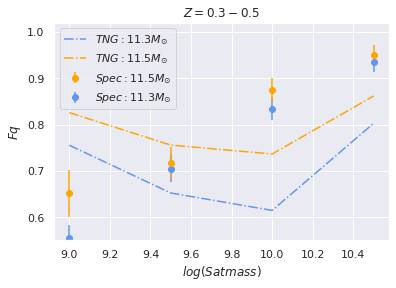

In [22]:
cen_bin = [11.3, 11.5, 11.7]
sate_bin = [9.0, 9.5, 10.0, 10.5,11.0]
color0 = ['cornflowerblue','orange']   #######e','seagreen',
for i in range(2):
    for j in range(4):
       
        if j==3:
            continue
        data = np.load("./result.npy")
        plt.errorbar(sate_bin[j],data[0][i][j],data[1][i][j],color = color0[i],fmt = 'o')
plt.errorbar(sate_bin[-2],data[0][1][3],data[1][1][3],color = color0[1],fmt = 'o',label = "$Spec : %s M_{\odot}$"%cen_bin[1])
plt.errorbar(sate_bin[3],data[0][0][3],data[1][0][3],color = color0[0],fmt = 'o',label = "$Spec : %s M_{\odot}$"%cen_bin[0])

TNG = np.load("./TNG_fq.npz")
plt.plot(sate_bin[:-1],TNG['version2'][0],color = color0[0],linestyle = '-.',label = "$TNG : 11.3 M_{\odot}$")
plt.plot(sate_bin[:-1],TNG['version2'][1],color = color0[1],linestyle = '-.',label = "$TNG : 11.5 M_{\odot}$")


plt.xlabel("$log(Sat mass)$")
plt.ylabel("$Fq$")
plt.legend(loc = "upper left")
plt.title("$Z = 0.3 - 0.5$")
plt.ylim(0.55,1.02)
# plt.plot()
plt.savefig("/home/yunzheng/PAC/picture/PCF_colorcut/Fq_0.3.pdf",dpi = 100)